## Loading in the Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random

## Function to read in the data as a pandas dataframe

In [2]:
def dataset_reader(datafile):
    
    return pd.read_csv(datafile)


## Class that perferoms Linear Regression:

In [34]:
class LinearRegression:
    """Class that performs Linear Regression
    
    Parameters:
    ---------------
    X- 
    y- Target
    learningRate- Learning Rate
    tolerance- Tolerance
    maxIteration- The maximum number of iterations
    lamda- The lamda value
    error- Method to calculate the error
    gd- Solve using Gradient Descent
    sgd- Solve using Stochastic Gradient Descent
    reg- Solve using Regularised Close Form Solution
    reg_gd- Solve using Regularised Gradient Descent
    """

    def __init__(self,X,y,learningRate,tolerance,lamda,maxIteration=50000,error='rmse',gd=False,sgd=False, reg=False, reg_gd=False):
        """Initialising the parameters"""
        self.X = X
        self.y = y
        self.learningRate = learningRate
        self.tolerance = tolerance
        self.maxIteration = maxIteration
        self.error = error
        self.lamda = lamda
        self.gd = gd
        self.sgd = sgd
        self.reg = reg
        self.reg_gd = reg_gd

    def splitTrainTest(self):
        """Function to Split the data into Training set and Test set"""
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, train_size = 0.2,
                                                            random_state = 0)
        return X_train, X_test, y_train, y_test
    
    def add_x0(self, X):
        """Function to add a column of ones to the dataset"""
        return np.column_stack([np.ones([X.shape[0], 1]), X])

    def normaize(self, X):
        """Function to normalize the Training dataset"""
        mean = np.mean(X)
        std = np.std(X)
        X_norm = (X - mean) / std
        X_norm = self.add_x0(X_norm)
        
        return X_norm, mean, std
    
    def normalizeTestData(self, X_test, train_mean, train_std):
        """Function to normalize the test dataset"""
        X_norm = (X_test - train_mean) / train_std
        X_norm = self.add_x0(X_norm)
        
        return X_norm
    
    def rank(self, X, eps = 1e-12):
        """Function to outupt the rank of the matrix"""
        u, s, vh = np.linalg.rank(X)
        
        return len([x for x in vh if abs(x) > eps])
    
    def checkMatrix(self, X):
        """Function to check the matrix"""
        X_rank = np.linalg.matrix_rank(X)
        
        if X_rank == min(X.shape[0], X.shape[1]):
            self.full_rank = True
            print("Data is full rank")
        else:
            self.full_rank = False
            print("Data is not full rank")
            
    def checkInvertibility(self, X):
        """Function to check the invertibility of the matrix"""
        if X.shape[0] < X.shape[1]:
            self.lowRank = True
            print("Matrix is low rank")
        else:
            self.lowRank = False
            print("Matrix is not low rank")
    
    def closedFormSolution(self, X, y):
        """Function to calculate the closed form solution for Linear Regression"""
        theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        
        return theta
    
    def regClosedForm(self, X, y):
        """Function to calculate the regularised closed form solution"""
        sizeofi = X.T.dot(X)
        identity = np.eye(sizeofi.shape[0],sizeofi.shape[1])
        self.theta = np.linalg.inv(X.T.dot(X)+self.lamda*identity).dot(X.T).dot(y)
        return self.theta
    
    def gradientDescent(self, X, y):
        """Function to solve using Gradient Descent"""
        #list to store the error values:
        errors = []
        last_error = float('inf')

        for t in tqdm(range(self.maxIteration)):
            self.theta = self.theta - self.learningRate * self.cost_derivative(X, y)

            if self.error == 'rmse':
                current_error = self.rmse(X, y)
            else:
                current_error = self.sse(X, y)
                
            error_difference = last_error - current_error
            last_error = current_error
            
            errors.append(current_error)
            
            if error_difference < self.tolerance:
                print("The model stopped learning - Converged")
                break

        self.plot_error(errors)

        return

    def regularisedGD(self, X, y):
        """Function to solve using regularised Gradient Descent"""
        #list to store the error values:
        errors = []
        last_error = float('inf')

        for t in tqdm(range(self.maxIteration)):
            self.theta = self.theta - self.learningRate * (self.cost_derivative(X, y) + (self.lamda * self.theta))

            if self.error == 'rmse':
                current_error = self.rmse(X, y)
            else:
                current_error = self.sse(X, y)
                
            error_difference = last_error - current_error
            last_error = current_error
            
            errors.append(current_error)
            
            if error_difference < self.tolerance:
                print("The model stopped learning - Converged")
                break

    
    def SGD(self, X, y):
        """Function to solve using Stochastic Gradient Descent"""
        #list to store the error values:
        errors = []
        last_error = float('inf')

        for t in tqdm(range(self.maxIteration)):
            index = [random.randint(0,X.shape[0]-1) for i in np.arange(1,100,1)]
            X = X[index]
            y = y[index]
            
            sigma = 0.0000001
            tau = 0.001
            
            alpha_t = sigma/(t + tau)
            
            self.theta = self.theta - alpha_t * (self.cost_derivative(X, y) + (self.lamda * self.theta))

            if self.error == 'rmse':
                current_error = self.rmse(X, y)
            else:
                current_error = self.sse(X, y)
                
            error_difference = last_error - current_error
            last_error = current_error
        
            errors.append(current_error)
           
            if abs(error_difference) < self.tolerance:
                print("The model stopped learning - Converged")
                break

        self.plot_error(errors)
        
        return

    def predict(self, X):
        """Function to predict using the test dataset"""
        return X.dot(self.theta)

    def sse(self, X, y):
        """Function to calculate the error using SSE"""
        y_hat = self.predict(X)

        return ((y_hat - y)**2).sum() #||X^T.Theta - y|| ^ 2
    
    def rmse(self, X, y):
        """Function to calculate the error using rmse"""
        return np.sqrt(self.sse(X, y) / X.shape[0])

    def cost_derivative(self, X, y):
        """Function to calculate the derivative based on the value of theta"""
        y_hat = self.predict(X) #X^T.Theta
        grad = (y_hat - y).dot(X) #X^T(Theta.X - y)
        
        return grad
        
    def plot_error(self, errors):
        """Function to plot the errors"""
        y_axis = errors
        x_axis = list(range(0,len(errors)))
            
        fig, ax = plt.subplots()
        ax.plot(x_axis,y_axis)
            
        ax.set (xlabel = 'Iterations', ylabel = 'Error', title = 'Cost Function')
        plt.show()
    
    def run_model(self):
        """Function that runs the model"""
        #Splitting the data:
        self.X_train, self.X_test, self.y_train, self.y_test = self.splitTrainTest()
        
        #normalise the data: 
        self.X_train, self.mean, self.std = self.normaize(self.X_train)
        self.X_test = self.normalizeTestData(self.X_test, self.mean, self.std)
        
        self.checkMatrix(self.X_train)
        self.checkInvertibility(self.X_train)
        
        if(self.full_rank and not self.lowRank and self.X_train.shape[0] <= 10000 
        and not self.gd and not self.sgd and not self.reg and not self.reg_gd):
            self.theta = self.closedFormSolution(self.X_train, self.y_train)
            test_sse = self.sse(self.X_test, self.y_test)
            test_rmse = self.rmse(self.X_test, self.y_test)
        elif self.gd:
            self.theta = np.ones(self.X_train.shape[1], dtype = np.float64) * 0
            self.gradientDescent(self.X_train, self.y_train)
            test_sse = self.sse(self.X_test, self.y_test)
            test_rmse = self.rmse(self.X_test, self.y_test)
        elif self.sgd:
            self.theta = np.ones(self.X_train.shape[1], dtype = np.float64) * 0
            self.SGD(self.X_train, self.y_train)
            test_sse = self.sse(self.X_test, self.y_test)
            test_rmse = self.rmse(self.X_test, self.y_test)
        elif self.reg_gd:
            self.theta = np.ones(self.X_train.shape[1], dtype = np.float64) * 0
            self.regularisedGD(self.X_train, self.y_train)
            test_sse = self.sse(self.X_test, self.y_test)
            test_rmse = self.rmse(self.X_test, self.y_test)
        elif self.reg:
            self.theta = self.regClosedForm(self.X_train, self.y_train)
            test_sse = self.sse(self.X_test, self.y_test)
            test_rmse = self.rmse(self.X_test, self.y_test)
        
        print(self.theta)
        print('SSE:', test_sse)
        print('RMSE:', test_rmse)

### Reading in the Housing Dataset 

In [5]:
df = dataset_reader('housing.csv')

df.head()

,0.00632,18,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24
0,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
1,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
2,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


### Closed Form Solution without Regularisation

In [9]:
test_1 = LinearRegression(df.values[:,0:-1], df.values[:,-1], learningRate=0.00001, tolerance=0.0000001,
                          lamda=0.001, gd=False, sgd=False, reg=False, reg_gd=False)

In [10]:
test_1.run_model()

Data is full rank
Matrix is not low rank
[-9.26658731e+02 -2.21546975e+01  7.02747161e+00  1.32975606e+01
  6.52554464e+01 -2.46852079e+03  7.73499367e+02  2.95052207e+00
 -1.88668991e+02  3.43652599e+01 -1.70754280e+00 -1.25290587e+02
  1.70405788e+00 -8.17555558e+01]
SSE: 9947.031412046732
RMSE: 4.961992027533276


### Closed Form Solution with Regularisation

In [11]:
test_1 = LinearRegression(df.values[:,0:-1], df.values[:,-1], learningRate=0.00001,tolerance=0.0000001,
                          lamda=0.001, gd=False, sgd=False, reg=True, reg_gd=False)

In [12]:
test_1.run_model()

Data is full rank
Matrix is not low rank
[  -5.85278591  -22.38868443   11.08772662   -0.65037657  -35.80095734
  -27.30923381  342.05809103    4.07295299 -154.59051747   30.80395029
   -1.83288209 -117.9191007     1.5154218  -111.3311706 ]
SSE: 10554.432996526684
RMSE: 5.111245851044393


### Gradient Desect without Regularisation

In [15]:
test_1 = LinearRegression(df.values[:,0:-1], df.values[:,-1], learningRate=0.00001, tolerance=0.0000001,
                          lamda=0.001, error='rmse', gd=True, sgd=False, reg=False, reg_gd=False)

 15%|██████████▉                                                               | 7364/50000 [00:00<00:00, 73081.28it/s]

Data is full rank
Matrix is not low rank


100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [00:00<00:00, 79904.35it/s]


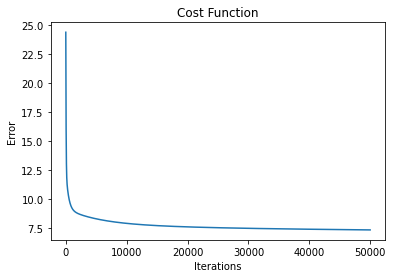

[  8.20691334  -6.58920731  10.28491854  -5.62052092  -3.91571116
  -3.89202415  -2.47047216  -5.21195187  -4.43872111  -2.86982406
  -1.88839459  -5.08472815   1.59262748 -11.87357956]
SSE: 22559.70846193013
RMSE: 7.472674389368911


In [16]:
test_1.run_model()

### Gradient Descent with Regularisation

In [17]:
test_1 = LinearRegression(df.values[:,0:-1], df.values[:,-1], learningRate=0.00001, tolerance=0.0000001,
                          lamda=0.001, error='rmse', gd=False, sgd=False, reg=False, reg_gd=True)

In [18]:
test_1.run_model()

 26%|██████████████████▊                                                      | 12859/50000 [00:00<00:00, 64901.02it/s]

Data is full rank
Matrix is not low rank


100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [00:00<00:00, 72218.51it/s]

[  8.20654408  -6.58845094  10.28266434  -5.61999981  -3.91553442
  -3.89185057  -2.4705717   -5.21169923  -4.43831402  -2.8699558
  -1.8883349   -5.08409078   1.59321826 -11.871453  ]
SSE: 22559.82533275626
RMSE: 7.472693745481151


### Stochastic Gradient Descent

In [35]:
test_1 = LinearRegression(df.values[:,0:-1], df.values[:,-1], learningRate=0.00001, tolerance=0.0000001,
                          lamda=0.001, error='rmse', gd=False, sgd=True, reg=False, reg_gd=False)

  3%|██                                                                         | 1401/50000 [00:00<00:06, 7029.45it/s]

Data is full rank
Matrix is not low rank


 54%|███████████████████████████████████████▊                                  | 26898/50000 [00:03<00:03, 6870.42it/s]

The model stopped learning - Converged


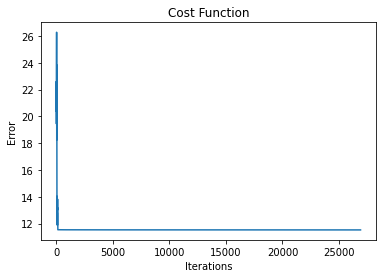

[ 0.23124728 -0.10782551 -0.0810986  -0.09481319 -0.11020288 -0.10944136
 -0.10029119 -0.02101599 -0.10393379 -0.09719619  0.47974555 -0.081406
  0.46834501 -0.09408022]
SSE: 193976.28101963282
RMSE: 21.91208135834058


In [36]:
test_1.run_model()

### Reading in the Concrete Dataset

In [37]:
df1 = dataset_reader('concreteData.csv')

df1.head()

,540,0,0.1,162,2.5,1040,676,28,79.99
0,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
1,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
3,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
4,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.03


### Closed Form Solution without Regularisation

In [38]:
test_2 = LinearRegression(df1.values[:,0:-1], df1.values[:,-1], learningRate=0.00001, tolerance=0.0000001,
                          lamda=0.001, gd=False, sgd=False, reg=False, reg_gd=False)

In [39]:
test_2.run_model()

Data is full rank
Matrix is not low rank
[144.42049143  46.61285438  41.45819372  37.51568723 -27.24652503
  84.45543671   7.5487383   13.84726964  35.98616704]
SSE: 91275.5196882124
RMSE: 10.524792718031996


### Closed Form Solution with Regularisation

In [40]:
test_2 = LinearRegression(df1.values[:,0:-1], df1.values[:,-1], learningRate=0.00001,tolerance=0.0000001,
                          lamda=0.001, gd=False, sgd=False, reg=True, reg_gd=False)

In [41]:
test_2.run_model()

Data is full rank
Matrix is not low rank
[136.82395014  46.72298938  41.54482416  37.70019034 -29.04688662
  75.23463534   7.32188838  13.78857405  35.93063533]
SSE: 91349.18528985139
RMSE: 10.529038976066543


### Gradient Descent without Regularisation

In [42]:
test_2 = LinearRegression(df1.values[:,0:-1], df1.values[:,-1], learningRate=0.00001, tolerance=0.0000001,
                          lamda=0.001, error='rmse', gd=True, sgd=False, reg=False, reg_gd=False)

 15%|███████████▏                                                              | 7601/50000 [00:00<00:01, 40442.68it/s]

Data is full rank
Matrix is not low rank


100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [00:00<00:00, 59988.04it/s]


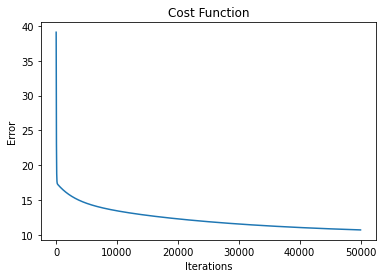

[ 31.43370108  40.69796092  32.34429209  19.30676878 -26.7109932
 -18.41257152   7.71530477  14.63054798  25.75075162]
SSE: 108422.13499070343
RMSE: 11.470843949380876


In [43]:
test_2.run_model()

### Gradient Descent with Regularisation

In [44]:
test_2 = LinearRegression(df1.values[:,0:-1], df1.values[:,-1], learningRate=0.00001, tolerance=0.0000001,
                          lamda=0.001, error='rmse', gd=False, sgd=False, reg=False, reg_gd=True)

In [45]:
test_2.run_model()

 22%|███████████████▊                                                         | 10836/50000 [00:00<00:00, 54545.68it/s]

Data is full rank
Matrix is not low rank


100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [00:00<00:00, 62361.06it/s]

[ 31.42821028  40.69305563  32.33808991  19.29943671 -26.70578154
 -18.40964323   7.715023    14.62850787  25.74574049]
SSE: 108431.58015843394
RMSE: 11.471343578380218


### Stochastic Gradient Descent

In [46]:
test_2 = LinearRegression(df1.values[:,0:-1], df1.values[:,-1], learningRate=0.00001, tolerance=0.0000001,
                          lamda=0.001, error='rmse', gd=False, sgd=True, reg=False, reg_gd=False)

  3%|██                                                                         | 1339/50000 [00:00<00:07, 6807.54it/s]

Data is full rank
Matrix is not low rank


 46%|██████████████████████████████████                                        | 23036/50000 [00:03<00:03, 7118.07it/s]

The model stopped learning - Converged


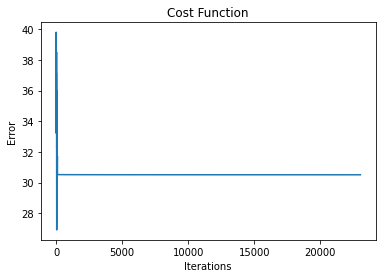

[ 0.36005267 -0.01617638 -0.20589134 -0.25609421 -0.12349355 -0.29828735
  0.68570393  0.48630325 -0.25894315]
SSE: 1105950.9273943726
RMSE: 36.6356855480513


In [47]:
test_2.run_model()

### Reading in the Yacht Dataset

In [48]:
df3 = dataset_reader('yachtData.csv')

df3.head()

,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
0,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
1,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
2,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
3,-2.3,0.568,4.78,3.99,3.17,0.225,1.18
4,-2.3,0.568,4.78,3.99,3.17,0.250,1.82


### Closed Form Solution without Regularisation

In [49]:
test_3 = LinearRegression(df3.values[:,0:-1], df3.values[:,-1], learningRate=0.00001, tolerance=0.0000001,
                          lamda=0.001, gd=False, sgd=False, reg=False, reg_gd=False)

In [50]:
test_3.run_model()

Data is full rank
Matrix is not low rank
[211.07681883   4.85421078 -59.8745781    0.89675092 -15.65939217
 -20.0896818  358.0980443 ]
SSE: 27664.703370893825
RMSE: 10.604628413297716


### Closed Form Solution with Regularisation

In [51]:
test_3 = LinearRegression(df3.values[:,0:-1], df3.values[:,-1], learningRate=0.00001,tolerance=0.0000001,
                          lamda=0.001, gd=False, sgd=False, reg=True, reg_gd=False)

In [52]:
test_3.run_model()

Data is full rank
Matrix is not low rank
[201.95604659   4.82787029 -72.62438967  -1.43936751 -14.42558948
 -16.54709768 352.23524493]
SSE: 27317.727851706215
RMSE: 10.537916027086556


### Gradient Descent without Regularisation

In [53]:
test_3 = LinearRegression(df3.values[:,0:-1], df3.values[:,-1], learningRate=0.00001, tolerance=0.0000001,
                          lamda=0.001, error='rmse', gd=True, sgd=False, reg=False, reg_gd=False)

 33%|████████████████████████                                                 | 16453/50000 [00:00<00:00, 82634.12it/s]

Data is full rank
Matrix is not low rank


100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [00:00<00:00, 84878.69it/s]


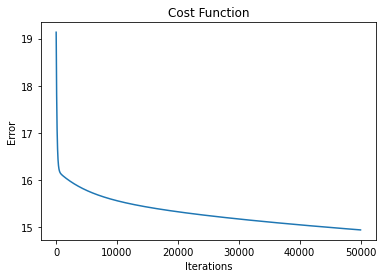

[ 8.65335778  4.86470662 -4.26279013 10.98290262 -4.81082171  9.3032055
 10.58245923]
SSE: 57003.90566080822
RMSE: 15.222456889185885


In [54]:
test_3.run_model()

### Gradient Descent with Regularisation

In [55]:
test_3 = LinearRegression(df3.values[:,0:-1], df3.values[:,-1], learningRate=0.00001, tolerance=0.0000001,
                          lamda=0.001, error='rmse', gd=False, sgd=False, reg=False, reg_gd=True)

In [56]:
test_3.run_model()

  8%|██████▎                                                                   | 4234/50000 [00:00<00:01, 39712.07it/s]

Data is full rank
Matrix is not low rank


100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [00:00<00:00, 72673.94it/s]

[ 8.65209136  4.86399307 -4.26212495 10.98132696 -4.80928465  9.30163673
 10.57936939]
SSE: 57003.35173867902
RMSE: 15.222382928672845


### Stochastic Gradient Descent

In [57]:
test_3 = LinearRegression(df3.values[:,0:-1], df3.values[:,-1], learningRate=0.00001, tolerance=0.0000001,
                          lamda=0.001, error='rmse', gd=False, sgd=True, reg=False, reg_gd=False)

  1%|▊                                                                           | 518/50000 [00:00<00:09, 5140.32it/s]

Data is full rank
Matrix is not low rank


  9%|██████▉                                                                    | 4609/50000 [00:00<00:07, 6369.64it/s]


The model stopped learning - Converged


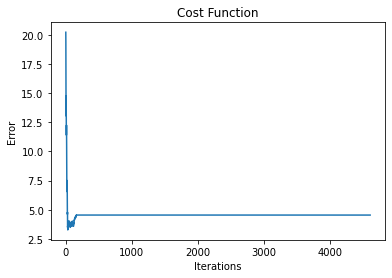

[ 0.11773399 -0.16785046 -0.05151523  0.13605586  0.09720233  0.06643654
 -0.05806268]
SSE: 78604.49222853793
RMSE: 17.875414854306705


In [58]:
test_3.run_model()